In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from gensim import models, corpora
from ast import literal_eval
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import umap
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета и предобработка

In [2]:
import pickle
with open('duma/data_dataframe_prep.pickle', 'rb') as dep:
    df = pickle.load(dep)

In [3]:
# Изначальный размер датасета
df.shape

(250675, 14)

In [4]:
df['lenght'] = df['lines'].apply(len)

In [5]:
# Удаление коротких текстов менее 20 слов
df['lenght'] = df['lines'].apply(len)
df = df[df['lenght']>=20].reset_index(drop=True)

In [6]:
df.head(10)

_startLine  _endLine     _type  \
0        5964      6009  65100007   
1        6024      6028             
2        5648      5696  65100003   
3         542       561             
4         621       642             
5         245       265             
6        1103      1123             
7        2517      2531             
8        2487      2502             
9        3873      3889             

                                              _lines _votes  \
0  фракция единая россия уважаемые коллеги уважае...     []   
1  как я уже сказал президентом россии предложен ...     []   
2  фракция единая россия добрый день уважаемая лю...     []   
3  фракция единая россия спасибо олег викторович ...     []   
4  фракция единая россия спасибо недавние события...     []   
5  фракция единая россия спасибо борис вячеславов...     []   
6  фракция единая россия спасибо борис вячеславов...     []   
7  фракция единая россия спасибо добрый день госп...     []   
8  фракция единая россия добрый день уважаемые ко...     []   
9  фракция справедливая россия у меня вопрос к пр...     []   

                        name pageSize page totalCount questionCount  \
0  Жолобов Олег Владимирович       20    1         12             9   
1  Жолобов Олег Владимирович       20    1         12             9   
2  Жолобов Олег Владимирович       20    1         12             9   
3  Жолобов Олег Владимирович       20    1         12             9   
4  Жолобов Олег Владимирович       20    1         12             9   
5  Жолобов Олег Владимирович       20    1         12             9   
6  Жолобов Олег Владимирович       20    1         12             9   
7  Жолобов Олег Владимирович       20    1         12             9   
8  Жолобов Олег Владимирович       20    1         12             9   
9    Тумусов Федот Семёнович       20    1        544           424   

         meetings.date  deputies  \
0  2009-06-11 00:00:00  99110188   
1  2009-06-11 00:00:00  99110188   
2  2009-06-05 00:00:00  99110188   
3  2008-12-10 00:00:00  99110188   
4  2008-10-10 00:00:00  99110188   
5  2008-09-10 00:00:00  99110188   
6  2008-05-21 00:00:00  99110188   
7  2008-03-12 00:00:00  99110188   
8  2008-03-05 00:00:00  99110188   
9  2020-03-12 00:00:00  99111067   

                                               party  \
0  Фракция Всероссийской политической партии "ЕДИ...   
1  Фракция Всероссийской политической партии "ЕДИ...   
2  Фракция Всероссийской политической партии "ЕДИ...   
3  Фракция Всероссийской политической партии "ЕДИ...   
4  Фракция Всероссийской политической партии "ЕДИ...   
5  Фракция Всероссийской политической партии "ЕДИ...   
6  Фракция Всероссийской политической партии "ЕДИ...   
7  Фракция Всероссийской политической партии "ЕДИ...   
8  Фракция Всероссийской политической партии "ЕДИ...   
9    Фракция Политической партии СПРАВЕДЛИВАЯ РОССИЯ   

                                               lines  lenght  
0  [фракция, единый, россия, уважаемый, коллега, ...     238  
1  [сказать, президент, россия, предлагать, иной,...      23  
2  [фракция, единый, россия, добрый, день, уважае...     241  
3  [фракция, единый, россия, спасибо, олег, викто...      87  
4  [фракция, единый, россия, спасибо, недавний, с...     110  
5  [фракция, единый, россия, спасибо, борис, вяче...     103  
6  [фракция, единый, россия, спасибо, борис, вяче...      97  
7  [фракция, единый, россия, спасибо, добрый, ден...      38  
8  [фракция, единый, россия, добрый, день, уважае...      78  
9  [фракция, справедливый, россия, вопрос, предст...      77

In [7]:
# Получившийся размер датасета
df.shape

(203327, 15)

In [8]:
df['meetings.date'] = pd.to_datetime(df['meetings.date'])
df[['party']].fillna(value='non_party', inplace=True)
df['year'] = df['meetings.date'].dt.year
df['year'] = df['year'].astype('int64')

In [9]:
def model(bag, ntopic=30):
    '''Функция обучения и получения модели тематического моделирования'''
    bigram = models.Phrases(bag, min_count=3, threshold=5) 
    bigram_mod = models.phrases.Phraser(bigram) 
    def make_bigrams(texts): 
        return [bigram_mod[doc] for doc in texts]
    texts = make_bigrams(bag)
    dictionary = corpora.Dictionary(texts) 
    dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6) 
    corpus = [dictionary.doc2bow(text) for text in texts] 
    ldamodel = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, eval_every=20, num_topics=ntopic, passes=5, random_state=2)
    return ldamodel, corpus

In [10]:
# Составляем мешок слов, поскольку предварительная обработка была проведена, то переводим строки в списки токенов
bag_of_words = df.lines

## Построение модели LDA

In [11]:
# Составляем мешок слов
bag_of_words = df.lines

In [12]:
%%time
# Обучаем модель
ldamodel, corpus = model(bag_of_words)

Wall time: 19min 56s


In [13]:
%%time
# Получение векторов тем
vector = pd.DataFrame([dict(i) for i in ldamodel.get_document_topics(corpus, minimum_probability=0)])

Wall time: 2min 10s


## Визуализация

##### Heatmap по годам

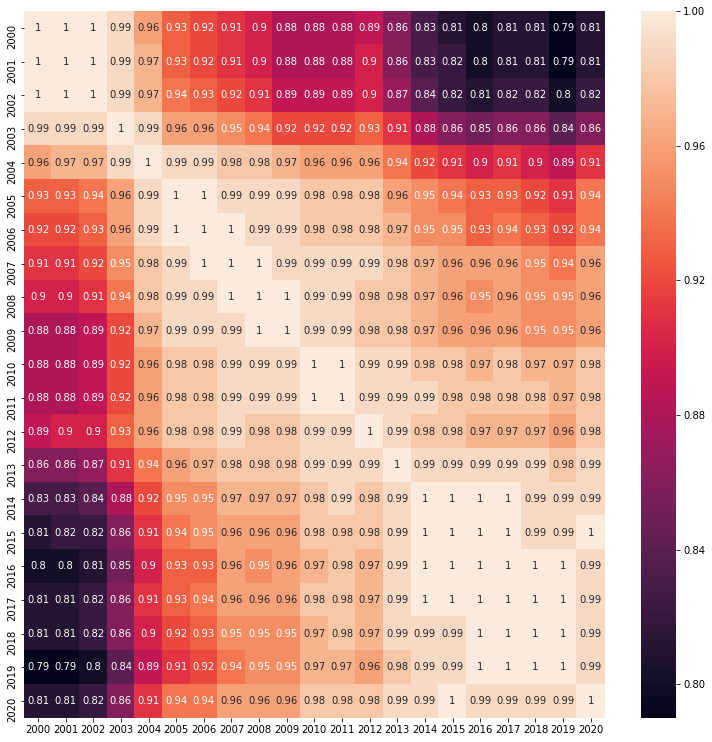

In [14]:
# Визуализация heatmap, показывающая насколько близки года по косинусному расстоянию между темами в стенограммах
total = pd.concat([df[['party', 'year']], vector], axis=1)
ind = total.groupby(['year']).mean().index
plt.figure(figsize=(13, 13))
sns.heatmap(np.round(cosine_similarity(total.groupby(['year']).mean()),2), annot=True, xticklabels=ind, yticklabels=ind)
plt.show()

In [15]:
# Таблица векторов тем по партиям и годам 
total.head(10)

party  year         0  \
0  Фракция Всероссийской политической партии "ЕДИ...  2009  0.000192   
1  Фракция Всероссийской политической партии "ЕДИ...  2009  0.002085   
2  Фракция Всероссийской политической партии "ЕДИ...  2009  0.000205   
3  Фракция Всероссийской политической партии "ЕДИ...  2008  0.000548   
4  Фракция Всероссийской политической партии "ЕДИ...  2008  0.000384   
5  Фракция Всероссийской политической партии "ЕДИ...  2008  0.000484   
6  Фракция Всероссийской политической партии "ЕДИ...  2008  0.000440   
7  Фракция Всероссийской политической партии "ЕДИ...  2008  0.001044   
8  Фракция Всероссийской политической партии "ЕДИ...  2008  0.000586   
9    Фракция Политической партии СПРАВЕДЛИВАЯ РОССИЯ  2020  0.025220   

          1         2         3         4         5         6         7  ...  \
0  0.000192  0.112172  0.000192  0.011853  0.021335  0.000192  0.000192  ...   
1  0.002085  0.002085  0.002085  0.002085  0.002085  0.002085  0.002085  ...   
2  0.000205  0.021385  0.000205  0.000205  0.000205  0.000205  0.028304  ...   
3  0.000548  0.000548  0.034299  0.103105  0.000548  0.000548  0.000548  ...   
4  0.000384  0.176382  0.000384  0.000384  0.000384  0.000384  0.000384  ...   
5  0.000484  0.026945  0.000484  0.000484  0.000484  0.000484  0.000484  ...   
6  0.000440  0.106835  0.069997  0.000440  0.122208  0.000440  0.000440  ...   
7  0.001044  0.149421  0.001044  0.001044  0.001044  0.001044  0.001044  ...   
8  0.053727  0.304558  0.000586  0.000586  0.000586  0.143671  0.000586  ...   
9  0.190193  0.000596  0.000596  0.023083  0.000596  0.000596  0.000596  ...   

         20        21        22        23        24        25        26  \
0  0.000192  0.072548  0.089154  0.000192  0.000192  0.000192  0.000192   
1  0.002085  0.315206  0.002085  0.626403  0.002085  0.002085  0.002085   
2  0.000205  0.064905  0.079342  0.000205  0.000205  0.018469  0.000205   
3  0.000548  0.134691  0.216257  0.000548  0.000548  0.000548  0.000548   
4  0.000384  0.451401  0.222747  0.000384  0.000384  0.000384  0.030164   
5  0.000484  0.250964  0.242470  0.000484  0.000484  0.000484  0.157413   
6  0.000440  0.104508  0.113937  0.026984  0.000440  0.000440  0.065728   
7  0.001044  0.001044  0.001044  0.318094  0.249018  0.036401  0.087581   
8  0.000586  0.000586  0.042016  0.000586  0.130892  0.000586  0.061561   
9  0.057580  0.153453  0.000596  0.000596  0.080447  0.000596  0.000596   

         27        28        29  
0  0.039249  0.000192  0.000192  
1  0.002085  0.002085  0.002085  
2  0.000205  0.000205  0.000205  
3  0.000548  0.018386  0.000548  
4  0.000384  0.000384  0.000384  
5  0.000484  0.000484  0.000484  
6  0.144578  0.000440  0.000440  
7  0.001044  0.001044  0.001044  
8  0.000586  0.000586  0.000586  
9  0.000596  0.030546  0.000596  

[10 rows x 32 columns]

##### UMAP визуализация по годам

In [16]:
party = total.groupby(['party', 'year']).mean().reset_index()
year = total.groupby(['year']).mean().reset_index()
um = umap.UMAP(metric='cosine', min_dist=0.0, random_state=0)
u1 = um.fit_transform(party.iloc[:,2:])
u2 = um.fit_transform(year.iloc[:,1:])
party = np.concatenate((party.iloc[:,:2], u1), axis=1)
year = np.concatenate((year.iloc[:,:1], u2), axis=1)

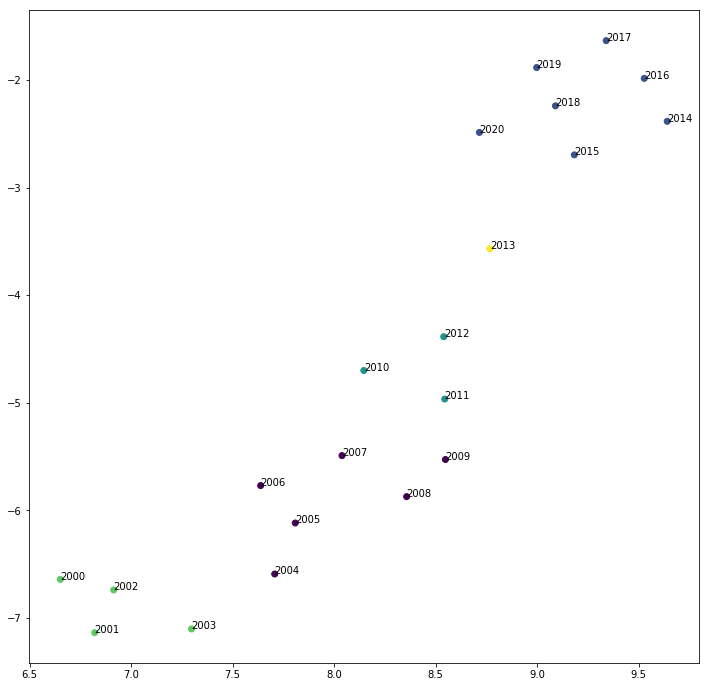

In [17]:
# Иерархическая кластеризация лет на 5 кластеров
AC = AgglomerativeClustering(5, affinity='cosine', linkage='average')
AC.fit(year[:,1:])
plt.figure(figsize=(12, 12))

plt.scatter(year[:,1], year[:,2], c=AC.labels_)
for x,y,z in zip(year[:,1], year[:,2], year[:,0]):
    label = "{}".format(int(z))
    plt.annotate(label, (x,y))
plt.show()

##### UMAP визуализация партий по годам

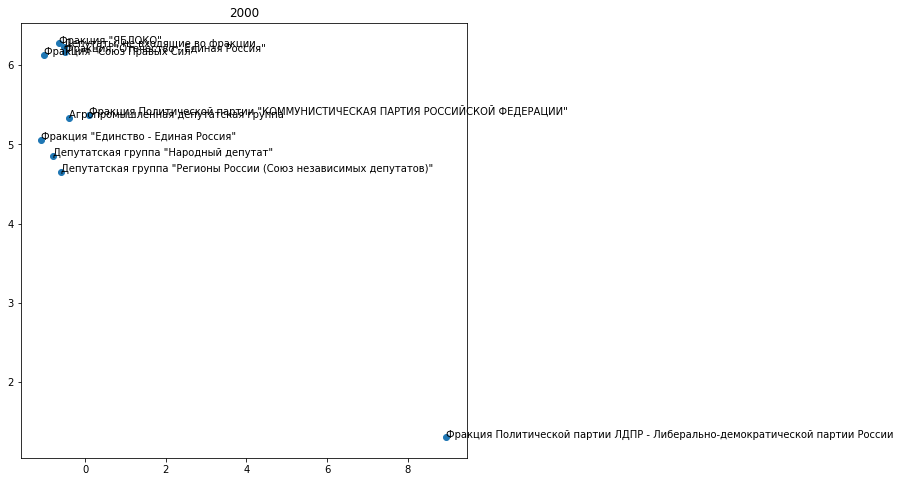

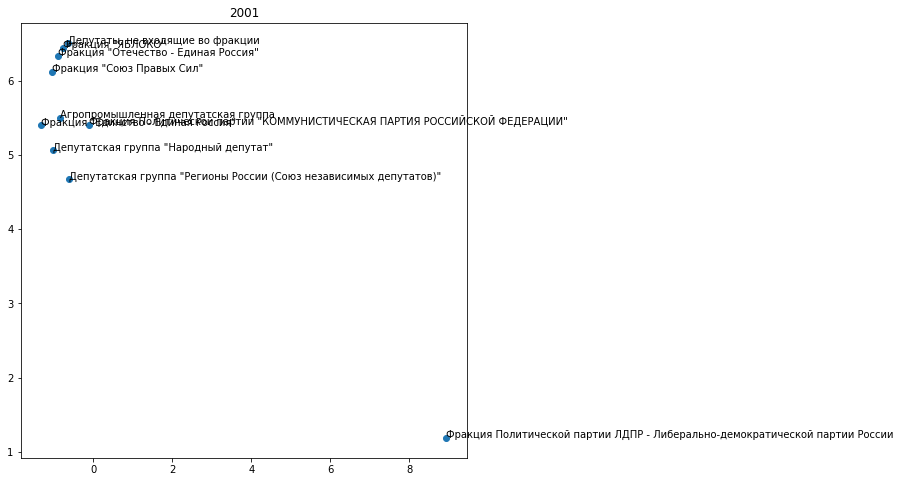

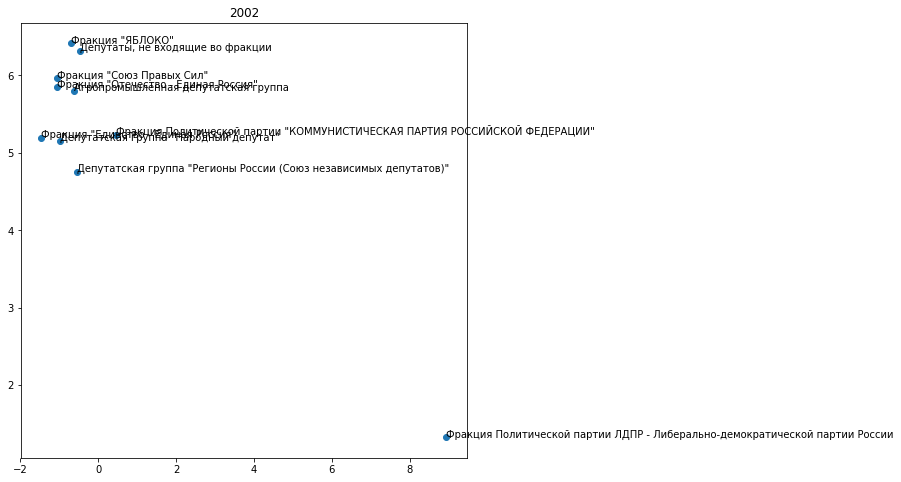

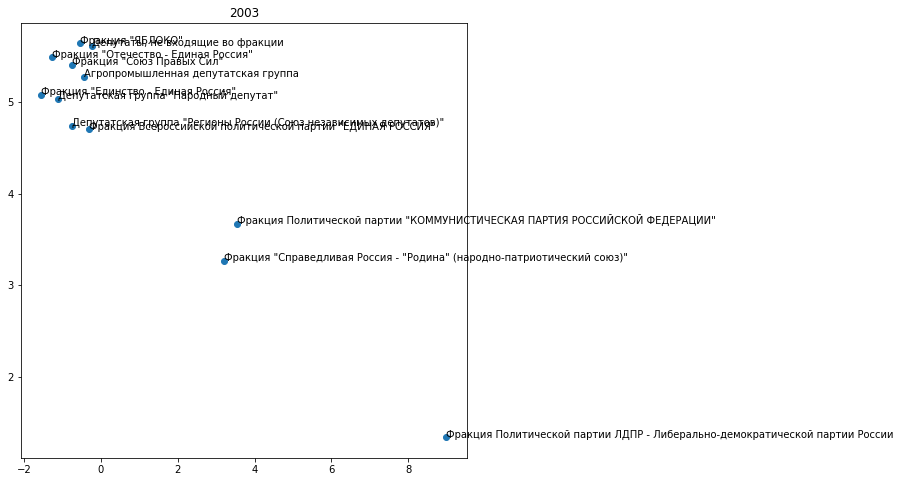

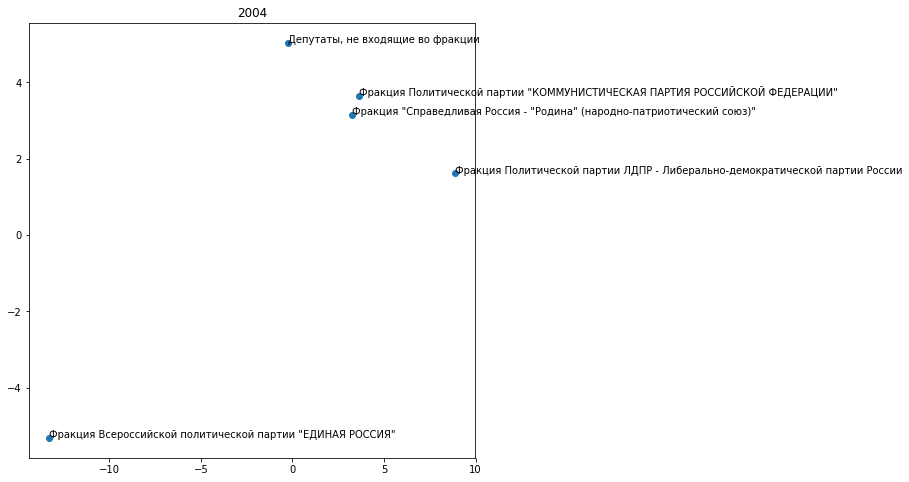

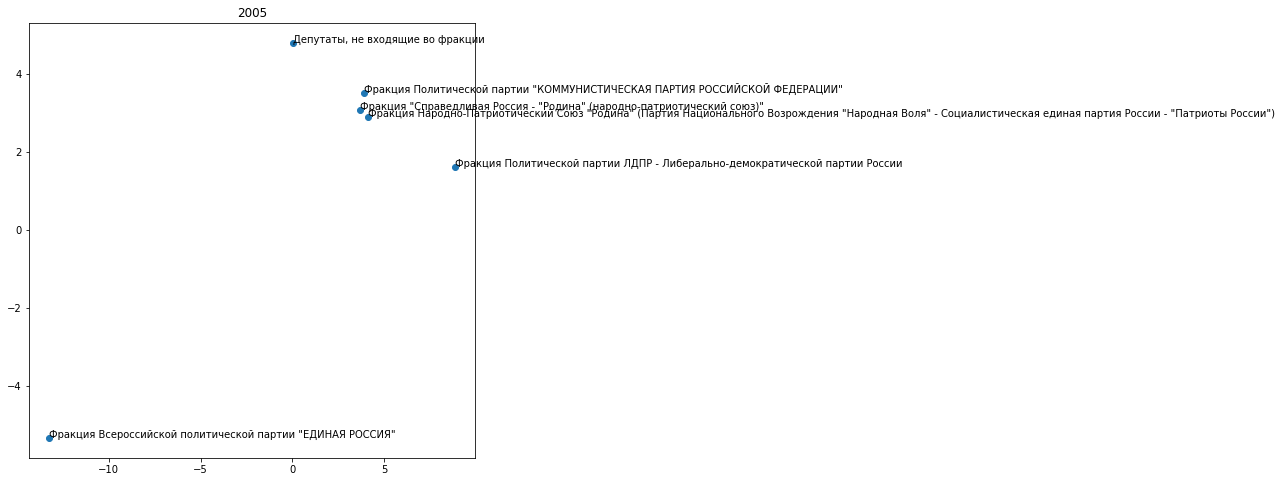

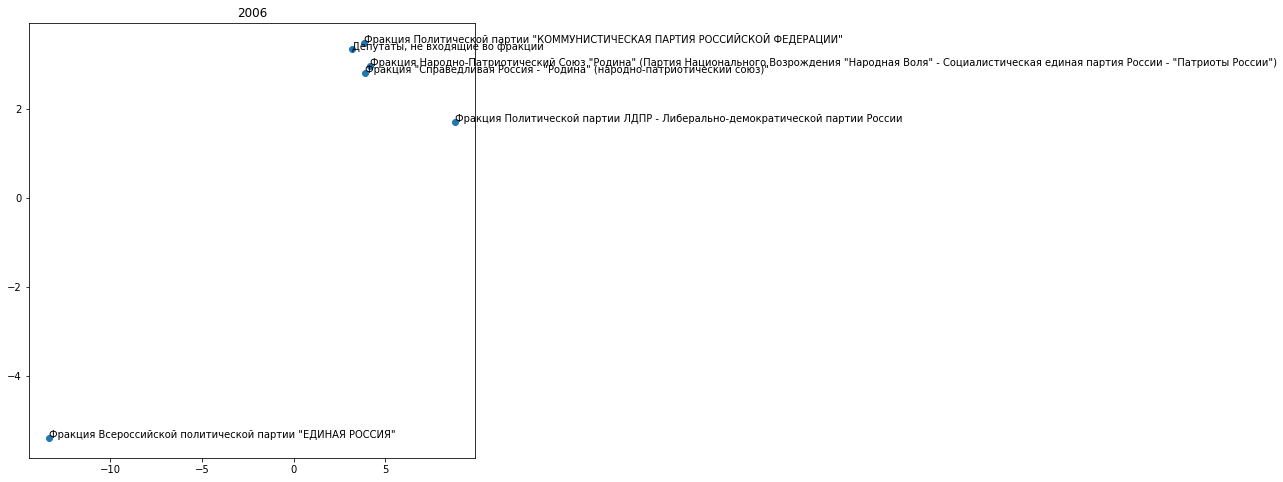

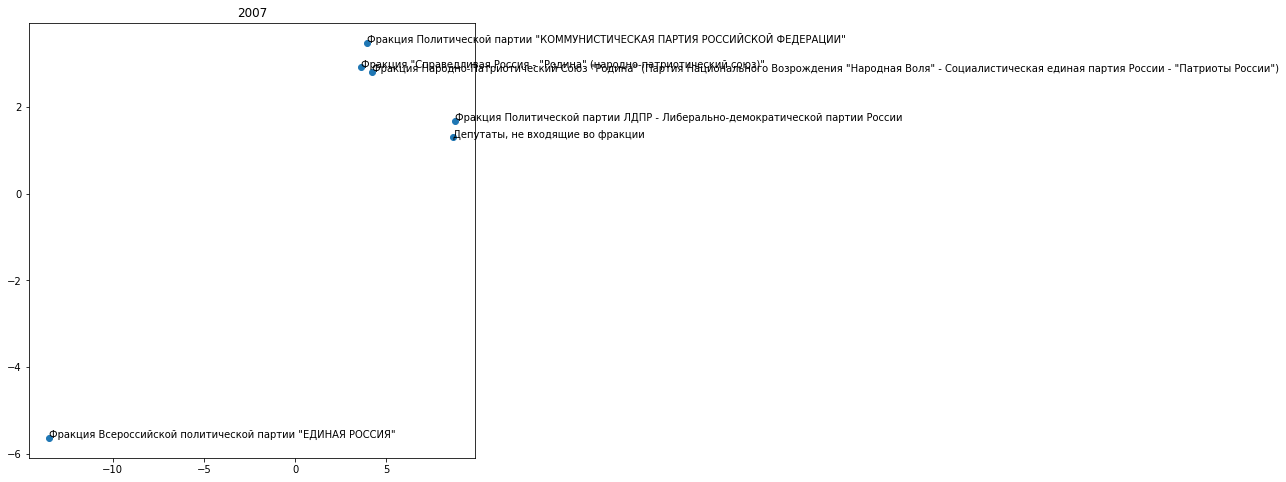

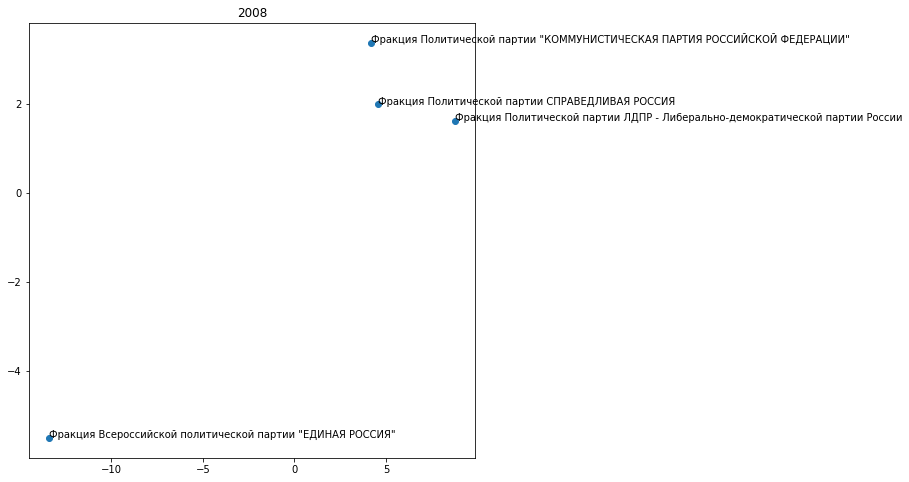

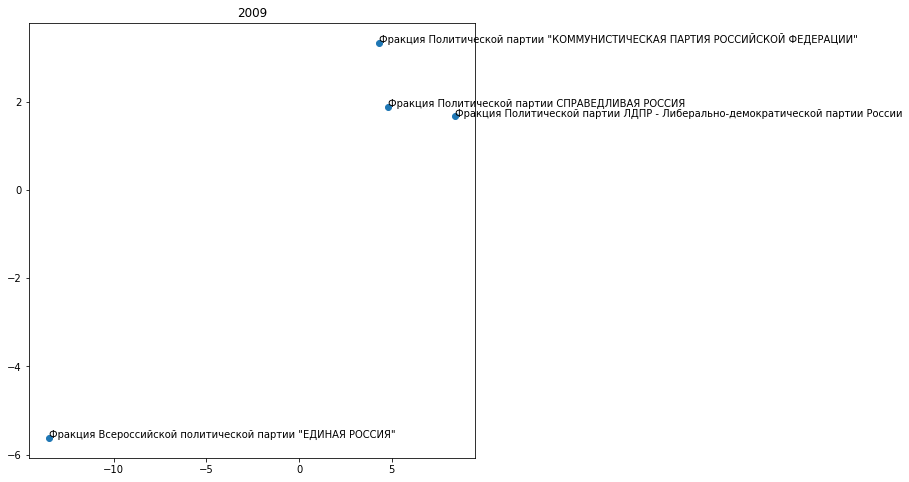

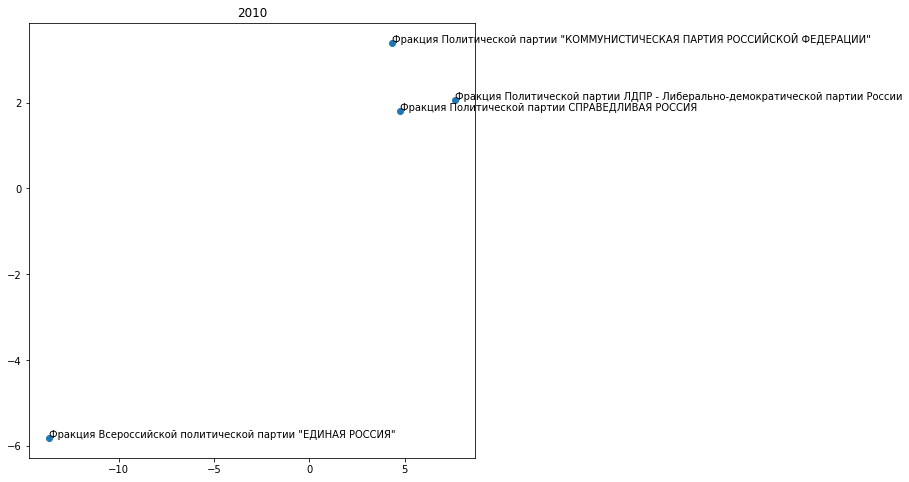

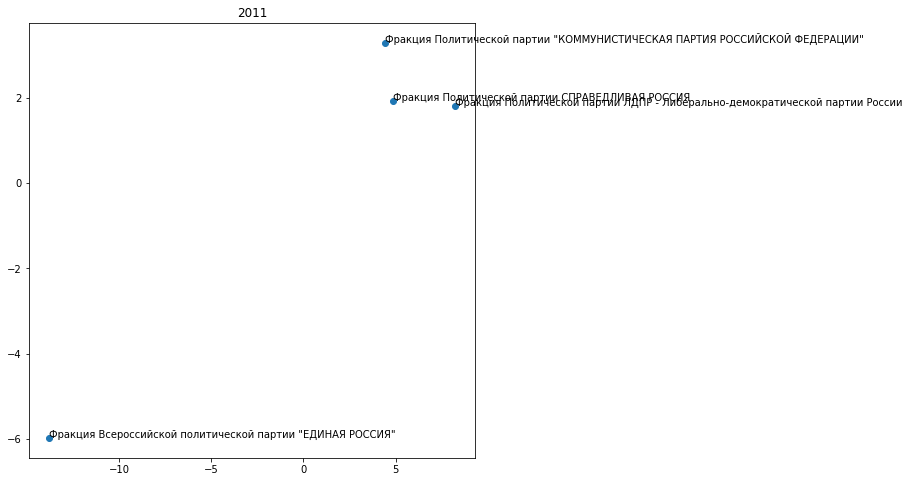

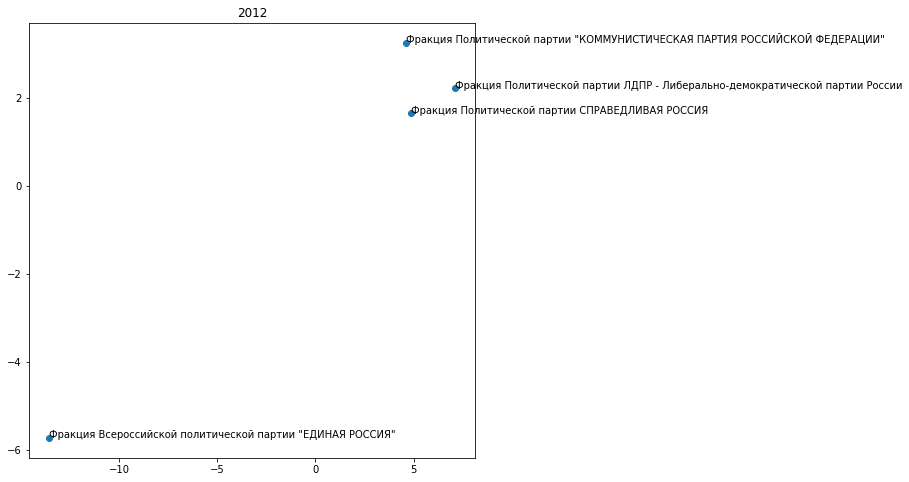

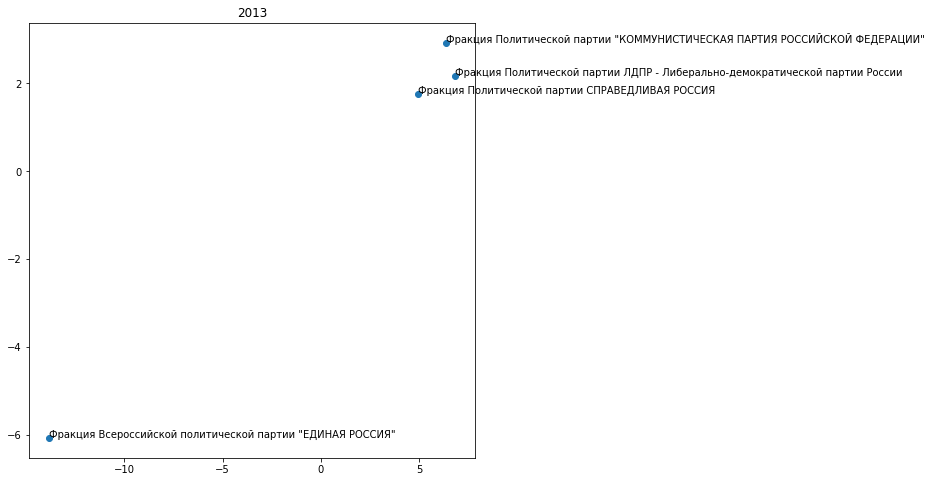

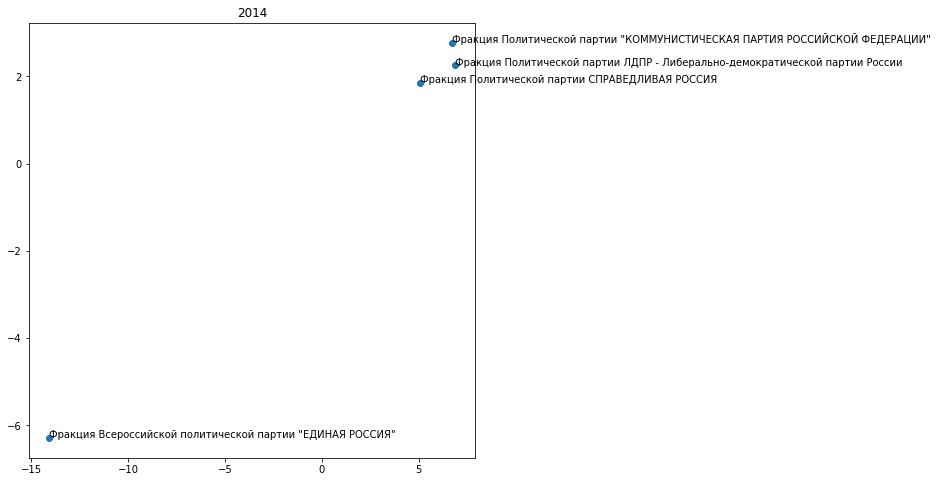

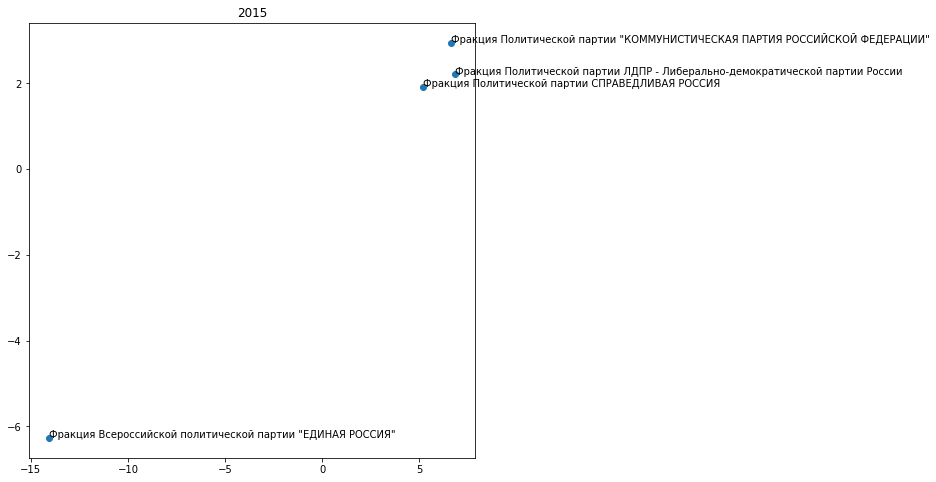

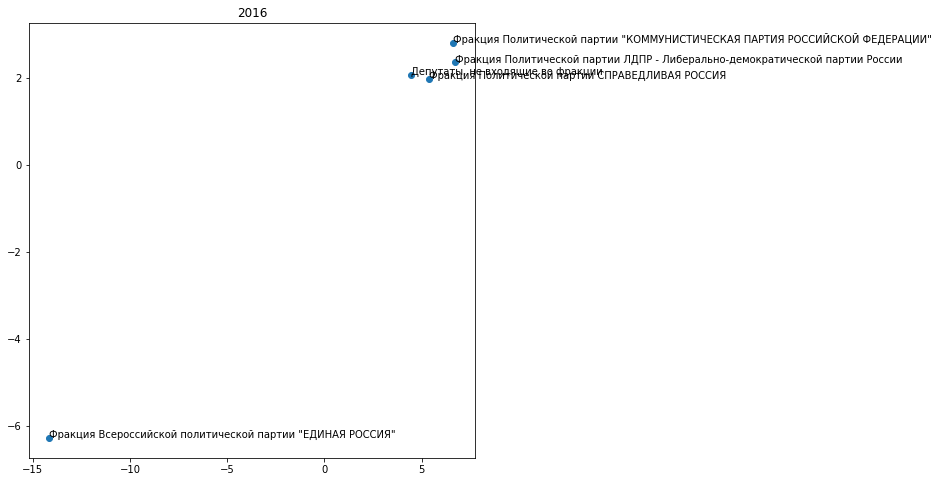

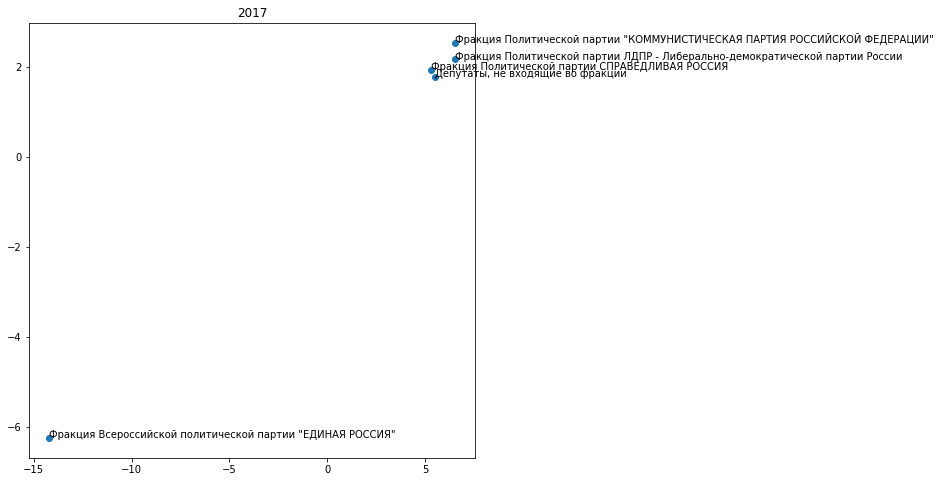

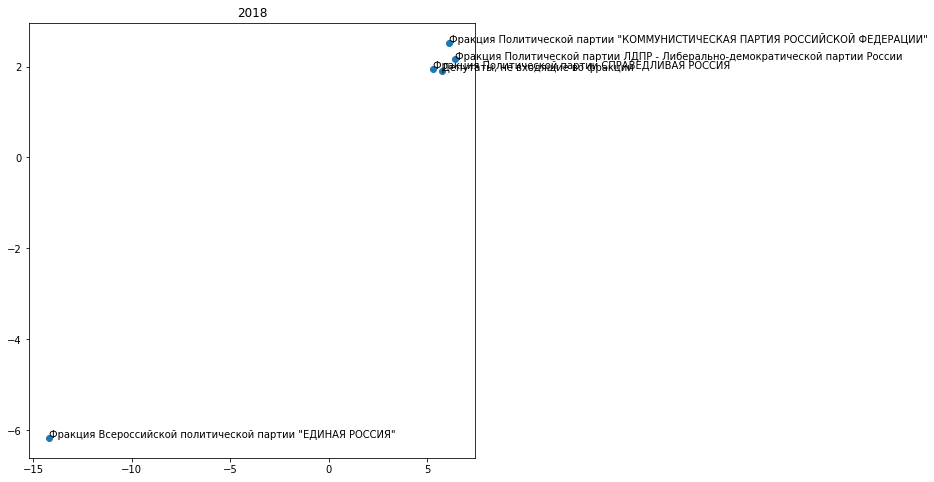

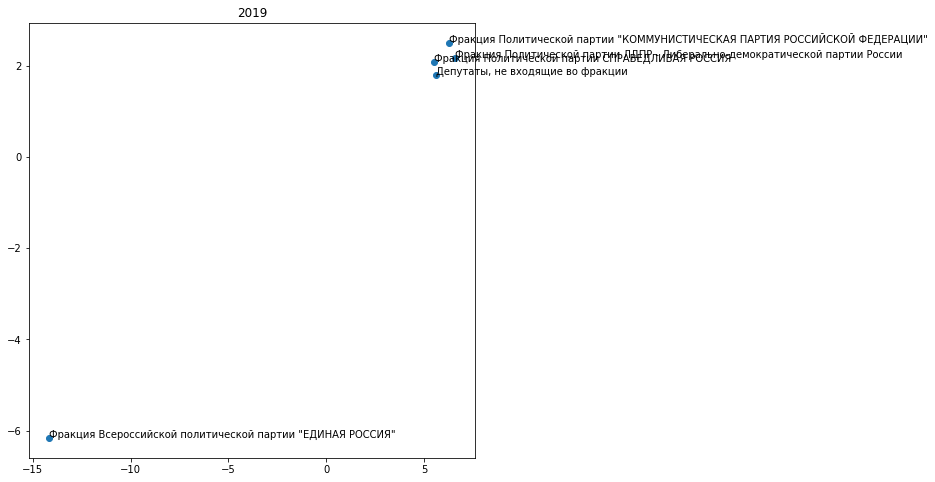

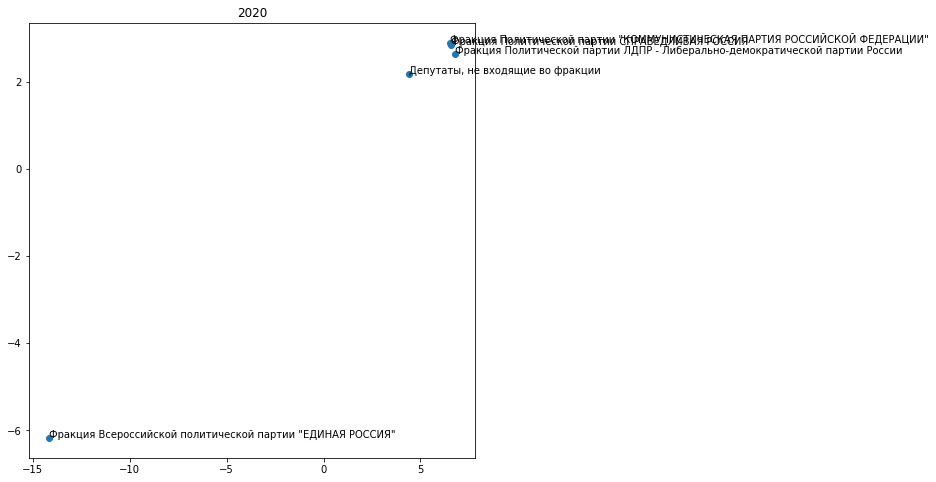

In [18]:
y = set(party[:,1])
j = 0
for i in y:
    p = np.array([x for x in party if x[1] == i])
    plt.figure(figsize=(8,8))
    plt.scatter(p[:,2], p[:,3])
    plt.title(i)
    for x,y,z in zip(p[:,2], p[:,3], p[:,0]):
        label = "{}".format(z)
        plt.annotate(label, (x,y))
    plt.show()

##### Топовые темы по годам

In [19]:
%%time
# Получение топовых тем по каждому оду отдельно
top = []
y = set(df.year)
for i in y:
    bag_of_words = df[df['year'] == i].lines
    ldamodel, _ = model(bag_of_words)
    top.append([i, ldamodel.show_topics(num_topics=30, num_words=20, formatted=False)[:6]])

Wall time: 17min 47s


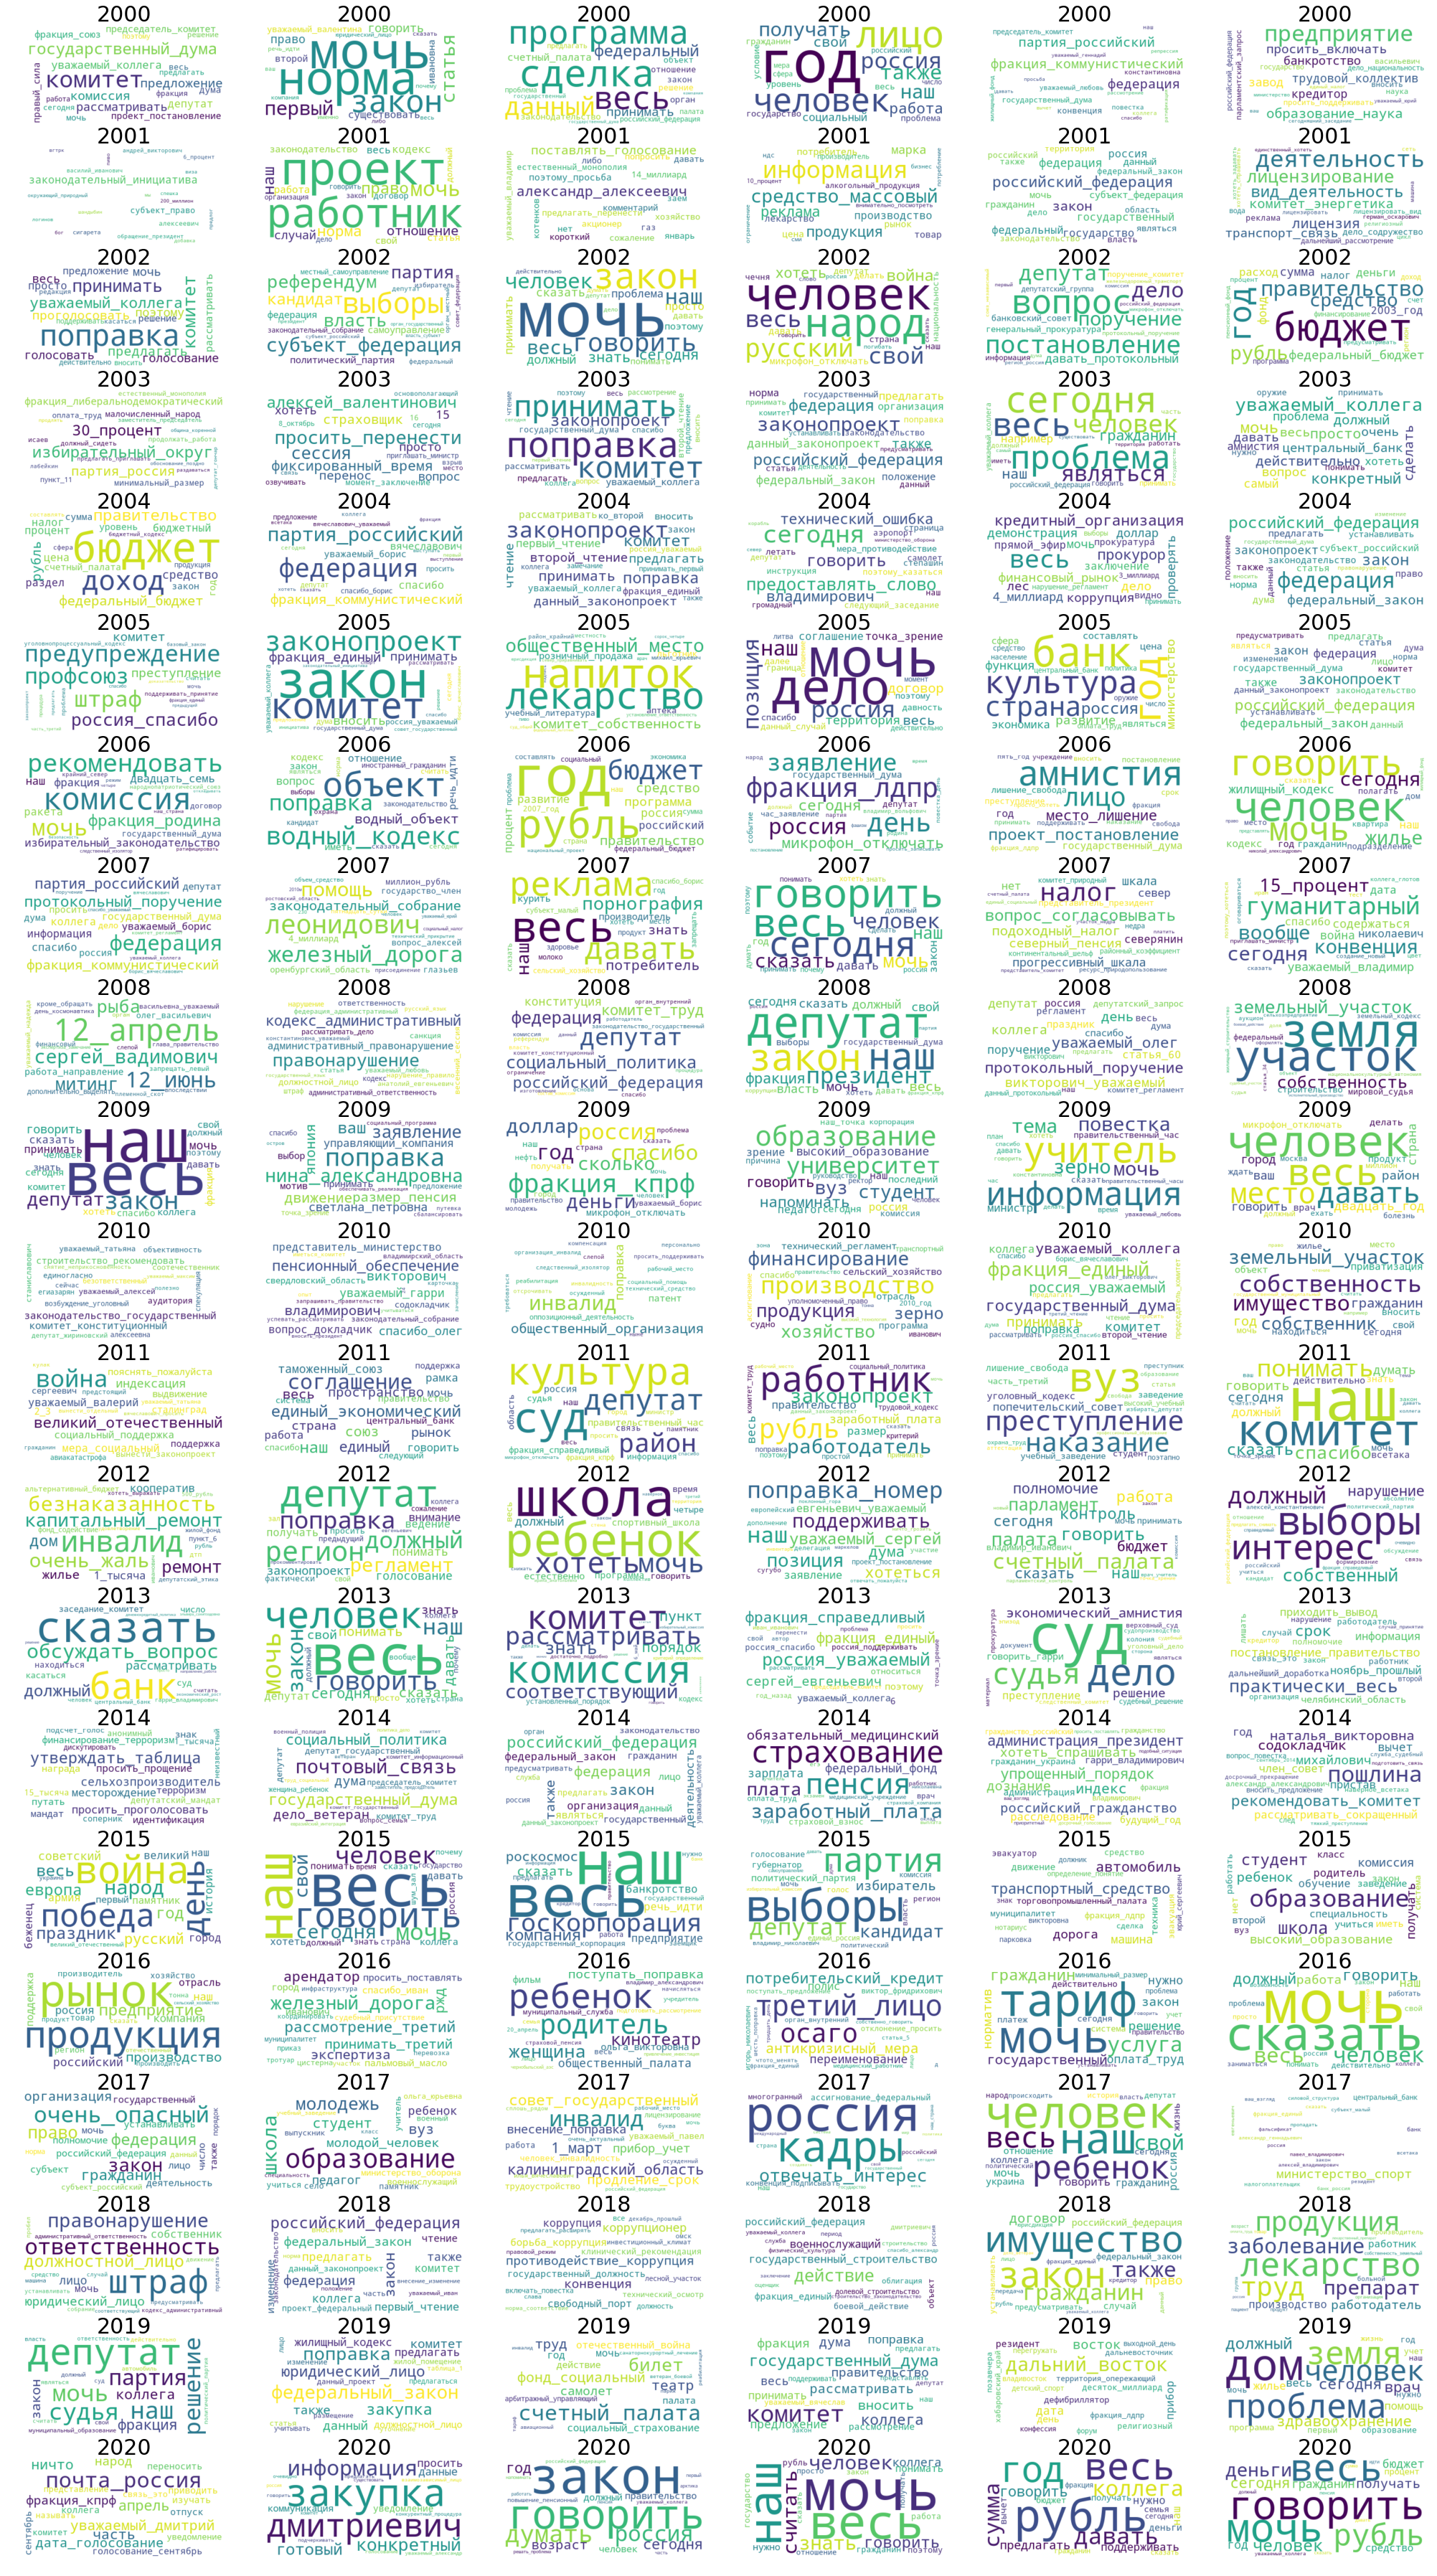

In [20]:
# Визуализация с помощью WordCloud
fig, axs = plt.subplots(21, 6, figsize=(35, 65))
j = 0
for i in top:
    topic = i[1]
    for k in topic:
        ax = axs[j//6,j%6]
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(k[1]))
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set(title = i[0])
        ax.title.set_size(30)
        j += 1

## Выводы:

- Очень отчётливо раздедились года по отдельным кластерам, что показывает Umap визуализация;
- Также отчетливо поделились партии по каждому году в отдельности;
- Часть тем удаётся интерпритировать по годам, часть нет.